# PSMA monthly analysis

In [110]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pycountry
from itertools import product

In [120]:
sns.set_style('white')
sns.set_context("paper", font_scale = 1.2)
color = sns.color_palette("tab10", 10)[0]

In [3]:
wd = '/Users/sebastiandodt/OneDrive/Uni/Carnegie Mellon University/Modules/2022 Fall/Systems Project/Coding/90739-iuu-systems-project/'

In [4]:
port_visits = pd.read_csv(wd + 'port_evaluation/data/input/GFW/unified/port_visit.csv')
top_10_percent = pd.read_csv(wd + 'port_evaluation/data/proc/GFW/top10percent.csv')

/var/folders/8z/3jxkd1111yv6m0gf9g9kqmdr0000gn/T/ipykernel_4262/1022794205.py:1: DtypeWarning: Columns (6,7,8,9,12,22,25,26,29,33,34,35,37,38,41,42,43,44,46,47,50,51) have mixed types. Specify dtype option on import or set low_memory=False.
  port_visits = pd.read_csv(wd + 'port_evaluation/data/input/GFW/unified/port_visit.csv')
/var/folders/8z/3jxkd1111yv6m0gf9g9kqmdr0000gn/T/ipykernel_4262/1022794205.py:2: DtypeWarning: Columns (11,12,13,14,15,42,43,44,47) have mixed types. Specify dtype option on import or set low_memory=False.
  top_10_percent = pd.read_csv(wd + 'port_evaluation/data/proc/GFW/top10percent.csv')


In [71]:
port_visits['datetime'] = pd.to_datetime(port_visits['event_start'])
port_visits['year'] = port_visits['datetime'].dt.year
port_visits['months_since_jan_2012'] = (port_visits['datetime'].dt.year - 2012) * 12 + port_visits['datetime'].dt.month - 1
port_visit_top10 = port_visits.loc[port_visits['vessel_id'].isin(top_10_percent['vessel.id']),:].reset_index(drop=True)

In [72]:
psma_entry = pd.read_excel(
    '/Users/sebastiandodt/OneDrive/Uni/Carnegie Mellon University/Modules/2022 Fall/Systems Project/Coding/90739-iuu-systems-project/port_evaluation/data/input/Law_Review/Law Review2.xlsx',
    sheet_name = 'PSMA'
)
psma_entry.drop(['Unnamed: 4', 'Unnamed: 5', 'Unnamed: 6'], axis=1, inplace = True)
psma_entry.columns = ['Country', 'Signature', 'Ratification', 'Status']
psma_entry['rat_year'] = psma_entry['Ratification'].str[:4].fillna(0).astype(int)
psma_entry['rat_year'] = psma_entry['rat_year'].replace(0,np.nan)
psma_entry['rat_month'] = psma_entry['Ratification'].str[5:7].fillna(0).astype(int)
psma_entry['rat_month'] = psma_entry['rat_month'].replace(0,np.nan)
psma_entry['psma_months_since_jan_2012'] = (psma_entry['rat_year']-2012) * 12 + psma_entry['rat_month'] - 1
psma_entry = psma_entry.loc[psma_entry['rat_year']>=2015,:] 
psma_entry = psma_entry.loc[psma_entry['rat_year']<=2019,:] 
psma_entry.head()

,Country,Signature,Ratification,Status,rat_year,rat_month,psma_months_since_jan_2012
0,ALB,NaT,2017-04-07 ACS,False,2017.0,4.0,63.0
2,AUS,2010-04-27,2015-07-20 RAT,True,2015.0,7.0,42.0
3,BHS,NaT,2016-10-07 ACS,False,2016.0,10.0,57.0
4,BGD,NaT,2019-12-20 ACS,False,2019.0,12.0,95.0
5,BRB,NaT,2016-02-02 ACS,False,2016.0,2.0,49.0


# Port visits in countries not ratified PSMA

In [73]:
plot_data1 = port_visit_top10.loc[~(port_visit_top10['flag'].isin(psma_entry['Country'])),:]
plot_data1 = plot_data1.groupby(['flag','months_since_jan_2012'])['event_id'].count().reset_index()

<AxesSubplot: xlabel='months_since_jan_2012', ylabel='event_id'>

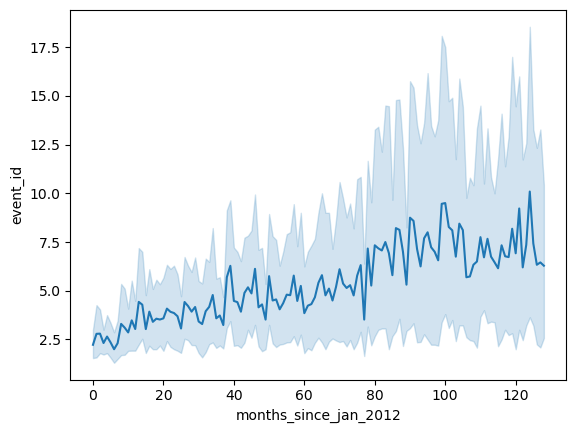

In [74]:
sns.lineplot(plot_data1,x='months_since_jan_2012', y='event_id')

# Port visits in countries that ratified PSMA

In [75]:
plot_data2 = port_visit_top10.loc[port_visit_top10['flag'].isin(psma_entry['Country']),:]
plot_data2 = plot_data2.merge(psma_entry, left_on='flag', right_on='Country', how='left')
plot_data2['months_since_PSMA'] = plot_data2['months_since_jan_2012'] - plot_data2['psma_months_since_jan_2012']
plot_data2['years_since_PSMA'] = plot_data2['months_since_PSMA'] // 12
plot_data2 = plot_data2.groupby(['flag','years_since_PSMA'])['event_id'].count().reset_index()

deleting first and last values

In [76]:
first_year = plot_data2.groupby('flag')['years_since_PSMA'].min().reset_index()
last_year = plot_data2.groupby('flag')['years_since_PSMA'].max().reset_index()
first_year['to_delete1'] = 1
last_year['to_delete2'] = 1
plot_data2 = plot_data2.merge(first_year, on=['flag', 'years_since_PSMA'], how='left')
plot_data2 = plot_data2.merge(last_year, on=['flag', 'years_since_PSMA'], how='left')
plot_data2 = plot_data2.loc[~(plot_data2['to_delete1']==1),:]
plot_data2 = plot_data2.loc[~(plot_data2['to_delete2']==1),:]

<AxesSubplot: xlabel='years_since_PSMA', ylabel='event_id'>

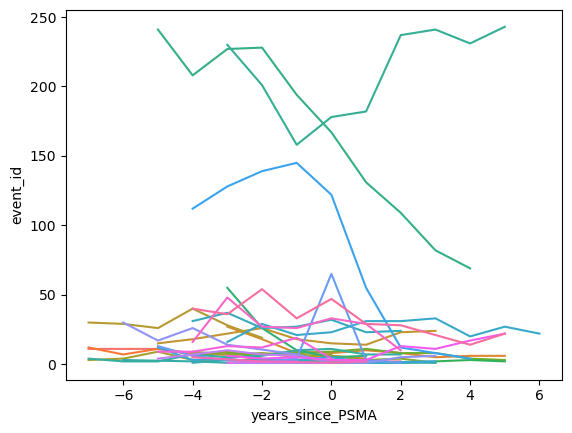

In [77]:
sns.lineplot(plot_data2,x='years_since_PSMA', y='event_id', hue='flag', legend=False)

normalising

In [78]:
plot_data3 = plot_data2.copy()
visits_in_rat_year = plot_data3.loc[plot_data3['years_since_PSMA']==0,:]
plot_data3['visits_normalised'] = np.nan
for country in plot_data3['flag'].unique():
    if country in visits_in_rat_year['flag'].unique():
        plot_data3.loc[plot_data3['flag'] == country,'visits_normalised'] = \
            100 * plot_data3.loc[plot_data3['flag'] == country,'event_id'] / float(visits_in_rat_year.loc[visits_in_rat_year['flag'] == country,'event_id'])

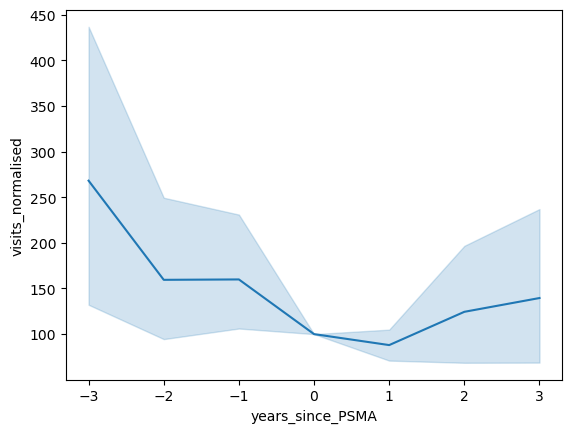

In [79]:
plot_data5 = plot_data3.copy()
plot_data5 = plot_data5.loc[plot_data5['years_since_PSMA'] >= -3,:]
plot_data5 = plot_data5.loc[plot_data5['years_since_PSMA'] <= 3,:]
sns.lineplot(plot_data5,x='years_since_PSMA', y='visits_normalised', legend=False)
plt.show()

filtering for most visited countries

In [80]:
ten_year_sum = plot_data3.groupby('flag')['event_id'].sum().reset_index()
filter = ten_year_sum.loc[ten_year_sum['event_id'] >= 200, 'flag']

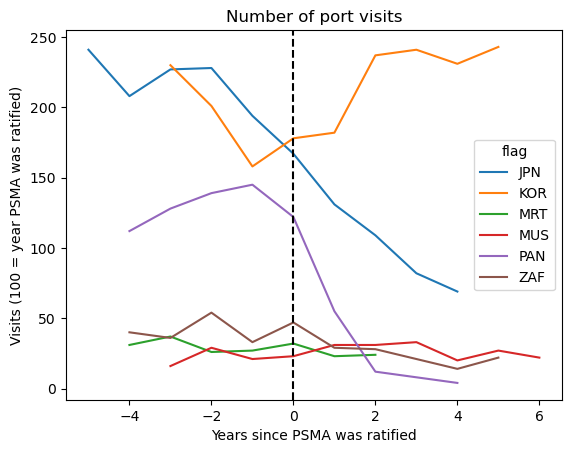

In [81]:
plot_data4 = plot_data3.copy() 
plot_data4 = plot_data4.loc[plot_data4['flag'].isin(filter),:]
sns.lineplot(plot_data4,x='years_since_PSMA', y='event_id', hue='flag', legend=True)
plt.title('Number of port visits')
plt.xlabel('Years since PSMA was ratified')
plt.ylabel('Visits (100 = year PSMA was ratified)')
plt.axvline(0, 0,1, color='black', linestyle='--')
plt.show()

Absolute values

In [129]:
regions = pd.read_csv('/Users/sebastiandodt/OneDrive/Uni/Carnegie Mellon University/Modules/2022 Fall/Systems Project/Coding/90739-iuu-systems-project/port_evaluation/data/input/regions/regions.csv')

In [172]:
country_data = [[country.alpha_3, country.alpha_2, country.name] for country in pycountry.countries]
country_data = pd.DataFrame(country_data, columns=['alpha_3', 'alpha_2', 'flag_country'])
country_data = country_data.merge(regions, left_on='alpha_3', right_on='alpha-3')
country_data.loc[country_data['name'] == 'Antarctica', 'name'] = 'Antarctica'
rename_dict = {'Korea, Republic of': 'Korea', 'Taiwan, Province of China': 'Taiwan', 'Russian Federation': 'Russia'}
for country in rename_dict.keys():
    country_data.loc[country_data['flag_country'] == country, 'flag_country'] = rename_dict[country]
country_data['name'] = country_data['name'].str[:15]

In [173]:
yearly_data = port_visit_top10.groupby(['flag', 'year'])[['event_id']].nunique().reset_index()
all_combinations = pd.DataFrame(list(product(yearly_data['flag'].unique(), yearly_data['year'].unique())), columns=['flag', 'year'])
yearly_data = all_combinations.merge(yearly_data, on=['flag', 'year'], how = 'left')
yearly_data['event_id'].fillna(0, inplace=True)

In [175]:
def plot_region(region_data, subregion):
    region_data = region_data.loc[region_data['year']<2022,:]
    region_data.rename({'name': 'Port Country', 'post_psma': 'after PSMA'}, axis=1, inplace=True)
    sns.lineplot(region_data,x='year', y='event_id', hue='Port Country', style='after PSMA', legend=True)
    plt.title('Number of port visits in {region}'.format(region=subregion))
    plt.xlabel('Year')
    plt.ylabel('Number of visits by top 10% most loitering reefers')
    if subregion == 'Sub-Saharan Africa':
        fontsize = 5
    else:
        fontsize = 8
    plt.legend(loc='upper left', fontsize=fontsize)
    plt.savefig(wd + 'port_evaluation/output/PSMA_regional/psma_{region}.png'
        .format(region=subregion),
        dpi=500)
    plt.show()

/var/folders/8z/3jxkd1111yv6m0gf9g9kqmdr0000gn/T/ipykernel_4262/8438966.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  region_data.rename({'name': 'Port Country', 'post_psma': 'after PSMA'}, axis=1, inplace=True)


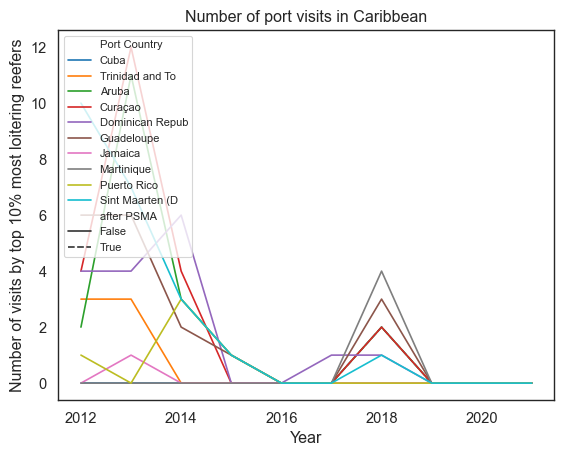

/var/folders/8z/3jxkd1111yv6m0gf9g9kqmdr0000gn/T/ipykernel_4262/3595042691.py:12: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rat_year.loc[:, 'post_psma'] = False
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


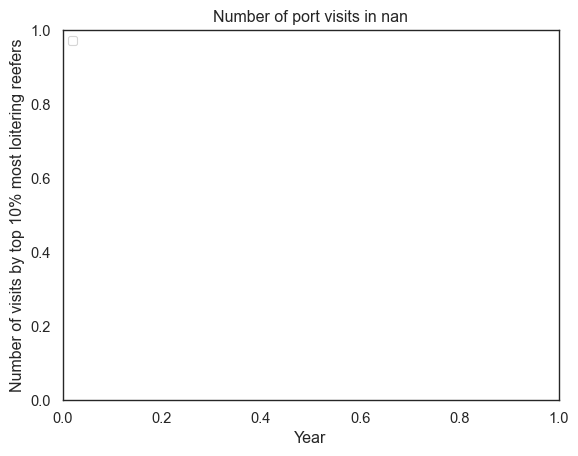

/var/folders/8z/3jxkd1111yv6m0gf9g9kqmdr0000gn/T/ipykernel_4262/8438966.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  region_data.rename({'name': 'Port Country', 'post_psma': 'after PSMA'}, axis=1, inplace=True)


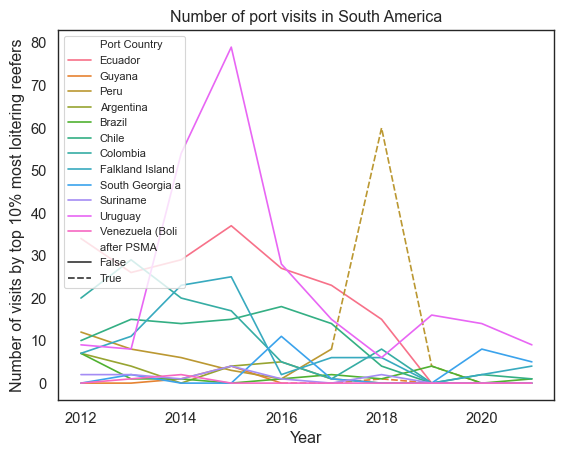

/var/folders/8z/3jxkd1111yv6m0gf9g9kqmdr0000gn/T/ipykernel_4262/8438966.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  region_data.rename({'name': 'Port Country', 'post_psma': 'after PSMA'}, axis=1, inplace=True)


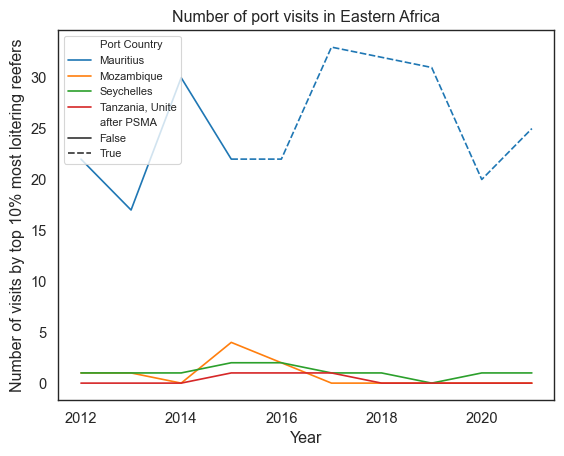

/var/folders/8z/3jxkd1111yv6m0gf9g9kqmdr0000gn/T/ipykernel_4262/8438966.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  region_data.rename({'name': 'Port Country', 'post_psma': 'after PSMA'}, axis=1, inplace=True)


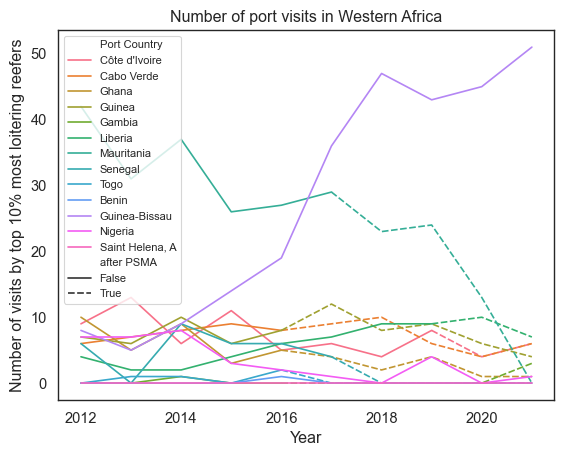

/var/folders/8z/3jxkd1111yv6m0gf9g9kqmdr0000gn/T/ipykernel_4262/8438966.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  region_data.rename({'name': 'Port Country', 'post_psma': 'after PSMA'}, axis=1, inplace=True)


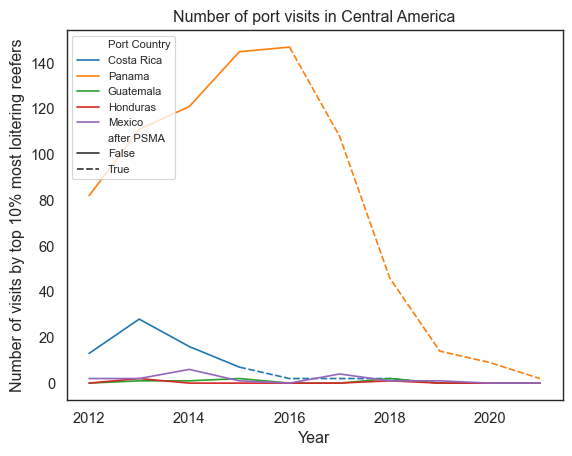

/var/folders/8z/3jxkd1111yv6m0gf9g9kqmdr0000gn/T/ipykernel_4262/8438966.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  region_data.rename({'name': 'Port Country', 'post_psma': 'after PSMA'}, axis=1, inplace=True)


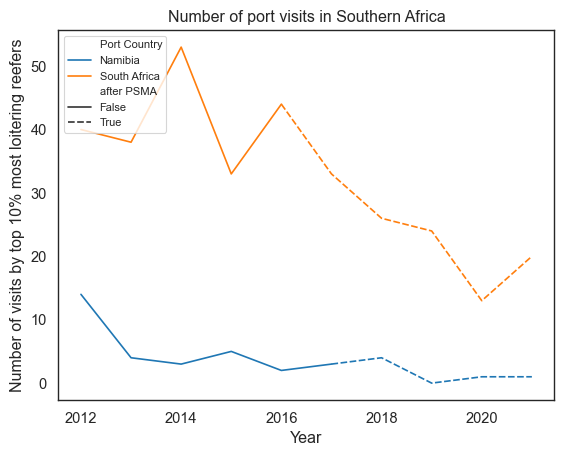

/var/folders/8z/3jxkd1111yv6m0gf9g9kqmdr0000gn/T/ipykernel_4262/8438966.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  region_data.rename({'name': 'Port Country', 'post_psma': 'after PSMA'}, axis=1, inplace=True)


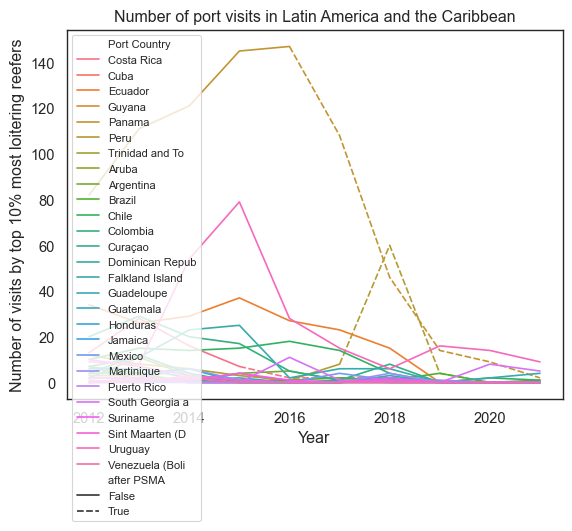

/var/folders/8z/3jxkd1111yv6m0gf9g9kqmdr0000gn/T/ipykernel_4262/8438966.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  region_data.rename({'name': 'Port Country', 'post_psma': 'after PSMA'}, axis=1, inplace=True)


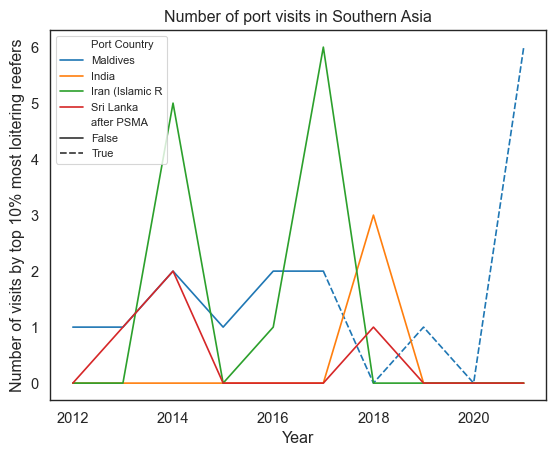

/var/folders/8z/3jxkd1111yv6m0gf9g9kqmdr0000gn/T/ipykernel_4262/8438966.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  region_data.rename({'name': 'Port Country', 'post_psma': 'after PSMA'}, axis=1, inplace=True)


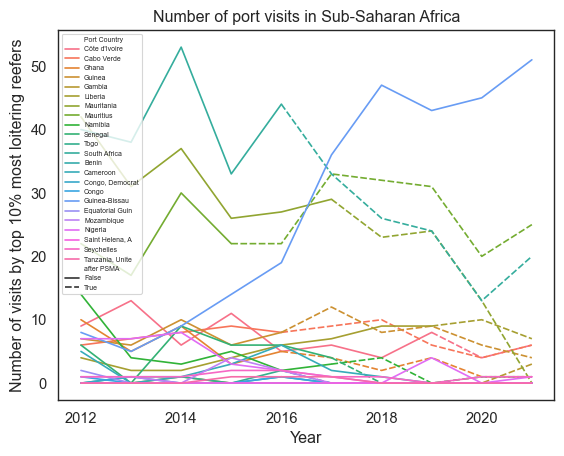

/var/folders/8z/3jxkd1111yv6m0gf9g9kqmdr0000gn/T/ipykernel_4262/8438966.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  region_data.rename({'name': 'Port Country', 'post_psma': 'after PSMA'}, axis=1, inplace=True)


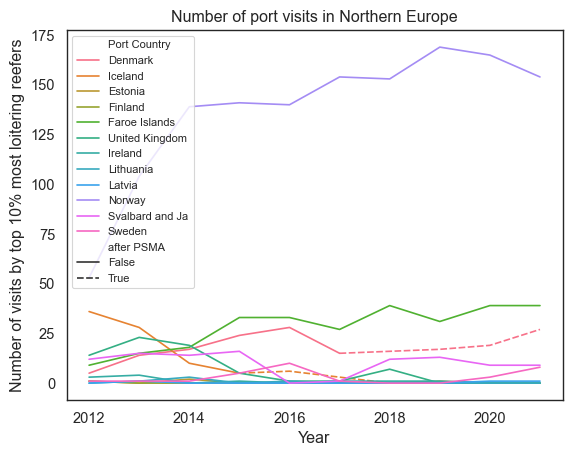

/var/folders/8z/3jxkd1111yv6m0gf9g9kqmdr0000gn/T/ipykernel_4262/3595042691.py:12: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rat_year.loc[:, 'post_psma'] = False
/var/folders/8z/3jxkd1111yv6m0gf9g9kqmdr0000gn/T/ipykernel_4262/8438966.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  region_data.rename({'name': 'Port Country', 'post_psma': 'after PSMA'}, axis=1, inplace=True)


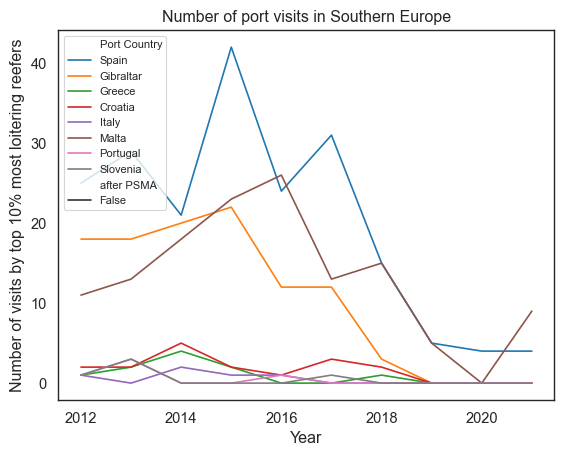

/var/folders/8z/3jxkd1111yv6m0gf9g9kqmdr0000gn/T/ipykernel_4262/8438966.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  region_data.rename({'name': 'Port Country', 'post_psma': 'after PSMA'}, axis=1, inplace=True)


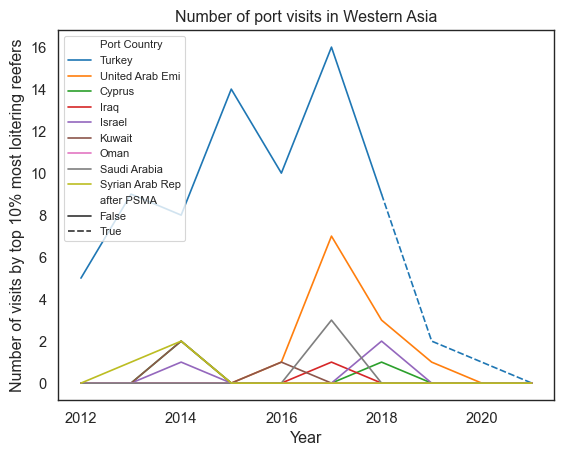

/var/folders/8z/3jxkd1111yv6m0gf9g9kqmdr0000gn/T/ipykernel_4262/3595042691.py:12: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rat_year.loc[:, 'post_psma'] = False
/var/folders/8z/3jxkd1111yv6m0gf9g9kqmdr0000gn/T/ipykernel_4262/8438966.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  region_data.rename({'name': 'Port Country', 'post_psma': 'after PSMA'}, axis=1, inplace=True)


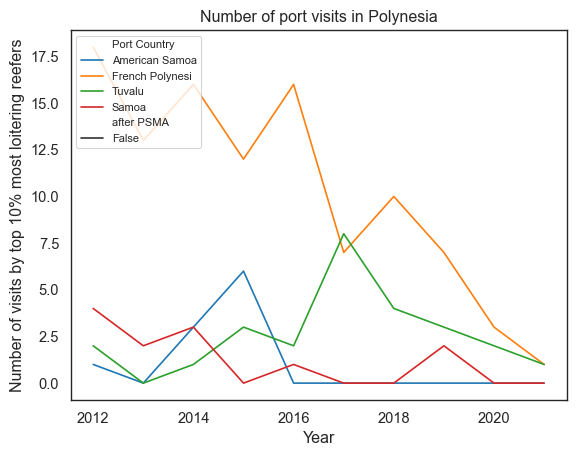

/var/folders/8z/3jxkd1111yv6m0gf9g9kqmdr0000gn/T/ipykernel_4262/3595042691.py:12: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rat_year.loc[:, 'post_psma'] = False
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


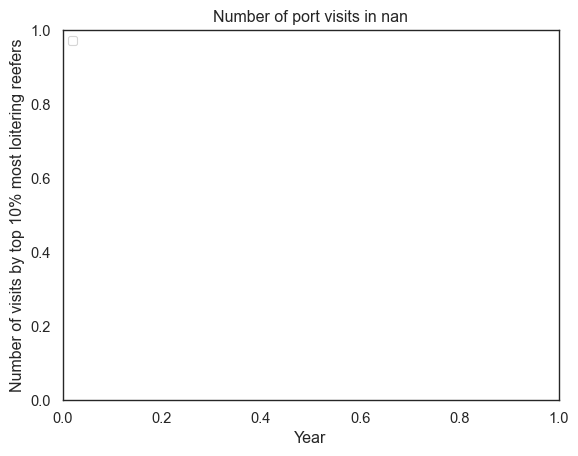

/var/folders/8z/3jxkd1111yv6m0gf9g9kqmdr0000gn/T/ipykernel_4262/8438966.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  region_data.rename({'name': 'Port Country', 'post_psma': 'after PSMA'}, axis=1, inplace=True)


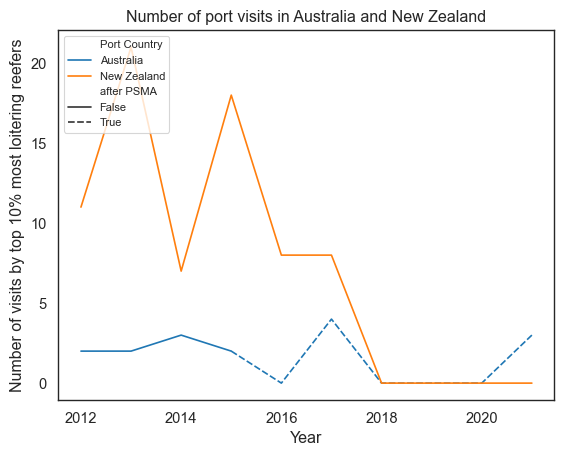

/var/folders/8z/3jxkd1111yv6m0gf9g9kqmdr0000gn/T/ipykernel_4262/8438966.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  region_data.rename({'name': 'Port Country', 'post_psma': 'after PSMA'}, axis=1, inplace=True)


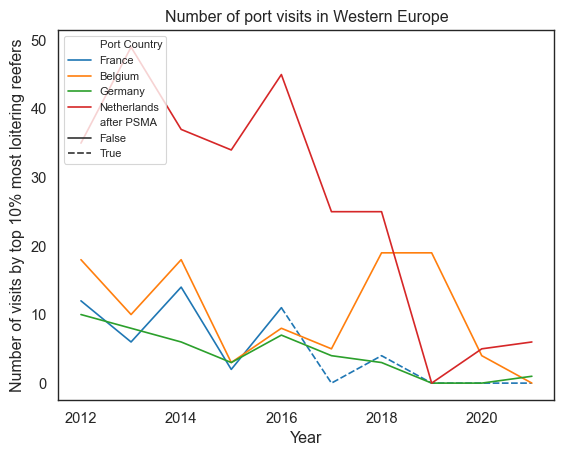

/var/folders/8z/3jxkd1111yv6m0gf9g9kqmdr0000gn/T/ipykernel_4262/3595042691.py:12: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rat_year.loc[:, 'post_psma'] = False
/var/folders/8z/3jxkd1111yv6m0gf9g9kqmdr0000gn/T/ipykernel_4262/8438966.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  region_data.rename({'name': 'Port Country', 'post_psma': 'after PSMA'}, axis=1, inplace=True)


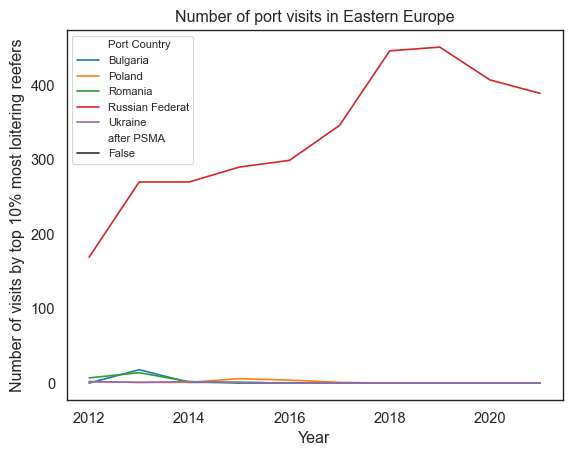

/var/folders/8z/3jxkd1111yv6m0gf9g9kqmdr0000gn/T/ipykernel_4262/8438966.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  region_data.rename({'name': 'Port Country', 'post_psma': 'after PSMA'}, axis=1, inplace=True)


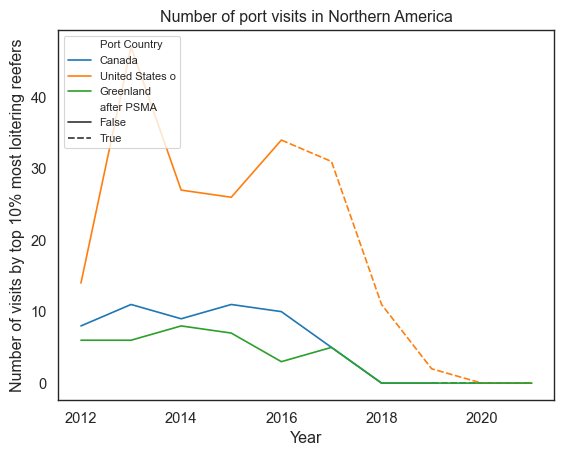

/var/folders/8z/3jxkd1111yv6m0gf9g9kqmdr0000gn/T/ipykernel_4262/8438966.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  region_data.rename({'name': 'Port Country', 'post_psma': 'after PSMA'}, axis=1, inplace=True)


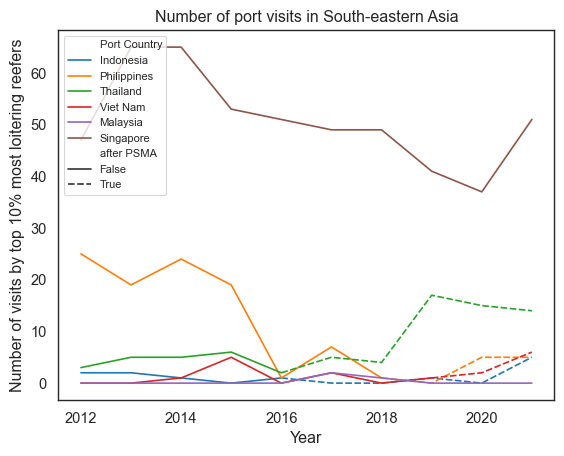

/var/folders/8z/3jxkd1111yv6m0gf9g9kqmdr0000gn/T/ipykernel_4262/8438966.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  region_data.rename({'name': 'Port Country', 'post_psma': 'after PSMA'}, axis=1, inplace=True)


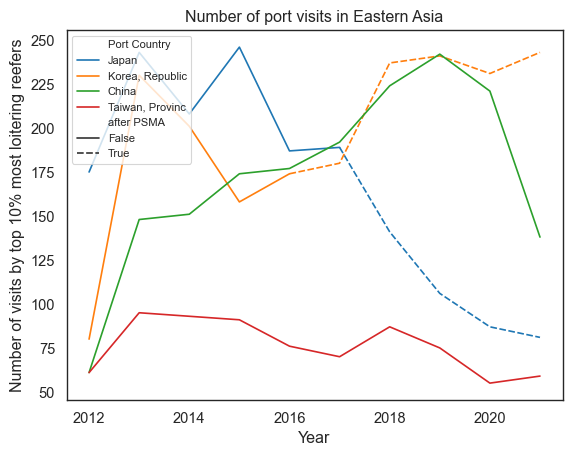

/var/folders/8z/3jxkd1111yv6m0gf9g9kqmdr0000gn/T/ipykernel_4262/8438966.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  region_data.rename({'name': 'Port Country', 'post_psma': 'after PSMA'}, axis=1, inplace=True)


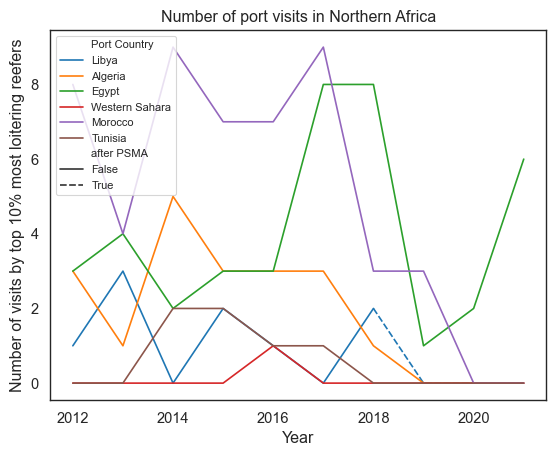

/var/folders/8z/3jxkd1111yv6m0gf9g9kqmdr0000gn/T/ipykernel_4262/8438966.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  region_data.rename({'name': 'Port Country', 'post_psma': 'after PSMA'}, axis=1, inplace=True)


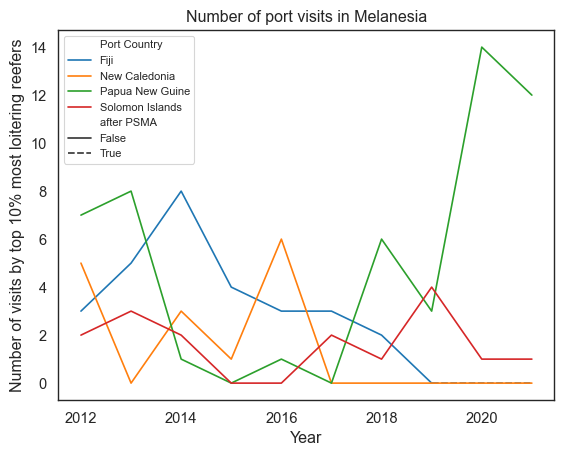

/var/folders/8z/3jxkd1111yv6m0gf9g9kqmdr0000gn/T/ipykernel_4262/8438966.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  region_data.rename({'name': 'Port Country', 'post_psma': 'after PSMA'}, axis=1, inplace=True)


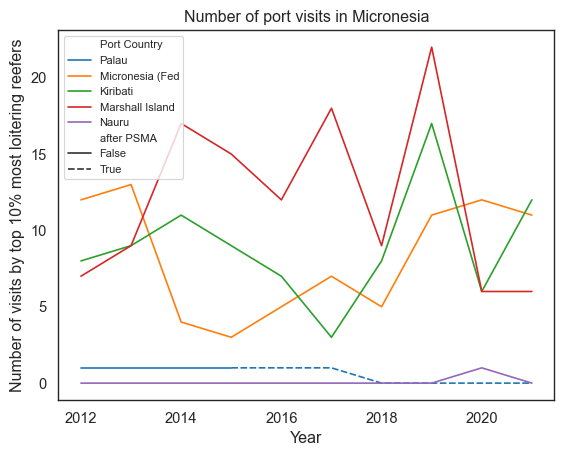

In [176]:
types = ['intermediate-region', 'sub-region']
for reg_type in types:
    subregions = country_data[reg_type].unique()
    for subregion in subregions:
        if subregion not in ['Central Asia', 'Middle Africa', 'Channel Islands']:
            region_data = yearly_data.loc[yearly_data['flag'].isin(country_data.loc[country_data[reg_type]==subregion,'alpha_3']),:]
            region_data = region_data.merge(psma_entry, left_on='flag', right_on='Country', how='left')
            region_data = region_data.merge(country_data, left_on='flag', right_on='alpha_3', how='left')
            region_data['years_since_psma'] = region_data['year'] - region_data['rat_year']
            region_data['post_psma'] = region_data['years_since_psma'] >= 0
            rat_year = region_data.loc[region_data['years_since_psma'] == 0,:].copy()
            rat_year.loc[:, 'post_psma'] = False
            region_data = pd.concat((rat_year, region_data), ignore_index=False)
            plot_region(region_data, subregion)

In [177]:
psma_entry

,Country,Signature,Ratification,Status,rat_year,rat_month,psma_months_since_jan_2012
0,ALB,NaT,2017-04-07 ACS,False,2017.0,4.0,63.0
2,AUS,2010-04-27,2015-07-20 RAT,True,2015.0,7.0,42.0
3,BHS,NaT,2016-10-07 ACS,False,2016.0,10.0,57.0
4,BGD,NaT,2019-12-20 ACS,False,2019.0,12.0,95.0
5,BRB,NaT,2016-02-02 ACS,False,2016.0,2.0,49.0
8,CPV,NaT,2016-06-23 ACS,False,2016.0,6.0,53.0
9,KHM,NaT,2019-11-06 ACS,False,2019.0,11.0,94.0
10,CAN,2010-11-19,2019-06-20 RAT,True,2019.0,6.0,89.0
12,CRI,NaT,2015-12-04 ACS,False,2015.0,12.0,47.0
13,CUB,NaT,2016-03-25 ACS,False,2016.0,3.0,50.0
